https://d2l.ai/chapter_computer-vision/semantic-segmentation-and-dataset.html

https://d2l.ai/chapter_computer-vision/fcn.html


In [4]:
import os
import torch
import torchvision
from d2l import torch as d2l

# Prepare Data

Go to http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#devkit. Then, download the [training/validation data](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar) (2GB tar file)

In [5]:
data_dir = r'E:\POSTDOC\PYTHON_CODES\DATASETS'
voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
print(voc_dir)

E:\POSTDOC\PYTHON_CODES\DATASETS\VOCdevkit/VOC2012


In [6]:
def read_voc_images(voc_dir, is_train=True):
    """
    Read all VOC feature and label images.
    """

    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    
    mode = torchvision.io.image.ImageReadMode.RGB
    
    with open(txt_fname, 'r') as f:
        images = f.read().split()
        
    features, labels = [], []
    
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))

    return features, labels

In [7]:
train_features, train_labels = read_voc_images(voc_dir, True)

In [8]:
print(type(train_features[0]))
print(train_features[0].shape)

<class 'torch.Tensor'>
torch.Size([3, 281, 500])


# Plot some images and their labels (segmentation maps)

In [9]:
import matplotlib.pyplot as plt

In [26]:
def plot_some_images(images, n):
    scale = 3
    fig, axs = plt.subplots(1, n, figsize=(n*scale, 1*scale))
    for i in range(n):
        axs[i].imshow(images[i].permute(1,2,0).numpy())
        axs[i].axis('off')
    plt.show()

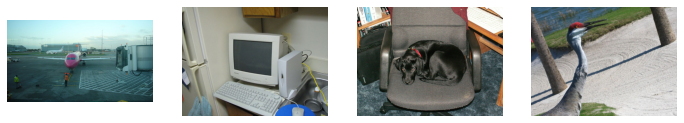

In [28]:
plot_some_images(train_features, n)

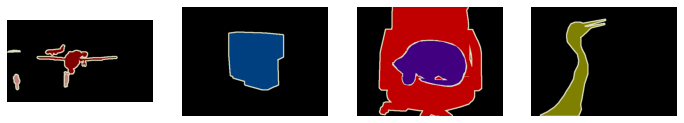

In [29]:
plot_some_images(train_labels, n)

# Utility functions (Map colors to labels)

In [30]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [31]:
def voc_colormap2label():
    """
    Build the mapping from RGB to class indices for VOC labels.
    """
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label


def voc_label_indices(colormap, colormap2label):
    """
    Map any RGB values in VOC labels to their class indices.
    """
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

Let's check the above two functions:

In [32]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
print(y[105:115, 130:140])

print(VOC_CLASSES[0])
print(VOC_CLASSES[1])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])
background
aeroplane


# A function for data augmentation

In [36]:
def voc_rand_crop(feature, label, height, width):
    """
    Randomly crop both feature and label images.
    """
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    
    feature = torchvision.transforms.functional.crop(feature, *rect)
    
    label = torchvision.transforms.functional.crop(label, *rect)
    
    return feature, label

Let's test it:

In [39]:
fs=[]
ls=[]
for _ in range(n):
    feature, label = voc_rand_crop(train_features[0], train_labels[0], 200, 300)
    fs.append(feature)
    ls.append(label)

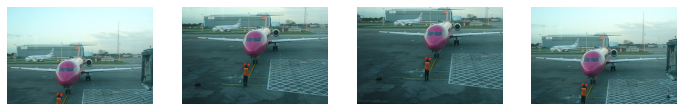

In [40]:
plot_some_images(fs,n)

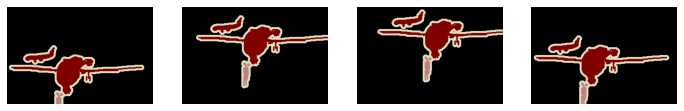

In [41]:
plot_some_images(ls,n)

# Define a custom Dataset class

In [43]:
class VOCSegDataset(torch.utils.data.Dataset):
    """
    A customized dataset to load the VOC dataset.
    """

    def __init__(self, is_train, crop_size, voc_dir):
        
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        self.crop_size = crop_size
        
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        
        # Only images which are bigger than the crop size are considered. 
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        
        self.colormap2label = voc_colormap2label()
        
        print('read ' + str(len(self.features)) + ' examples')
        

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [47]:
def get_voc_dataloaders(batch_size, crop_size):
    """
    batch_size = 64
    crop_size = (320, 480)
    trainloader, testloader = get_voc_dataloaders(batch_size, crop_size)
    """
    trainloader = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,shuffle=True, drop_last=True)
    
    testloader = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size, drop_last=True)
    
    return trainloader, testloader

In [48]:
batch_size = 64
crop_size = (320, 480)
trainloader, testloader = get_voc_dataloaders(batch_size, crop_size)

for X, Y in trainloader:
    print(X.shape)
    print(Y.shape)
    break

read 1114 examples
read 1078 examples
torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


Note that different from image classification or object detection, labels are three-dimensional tensors.

In [9]:
import inspect
lines = inspect.getsource(d2l.show_images)
print(lines)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

